In [17]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [18]:

import re
import ast

def fully_robust_parser(s):
    if isinstance(s, list):
        return s  # Already parsed
    # Remove newlines and normalize spaces
    s = re.sub(r'\s+', ' ', s.strip())
    # Remove brackets temporarily
    s_clean = s.strip('[]')
    # Add a comma between numbers that are not separated by a comma (handles floats like '1. 0.8')
    s_clean = re.sub(r'(?<=[\d.]) (?=[\d.-])', ', ', s_clean)
    # Wrap again in brackets
    s_clean = f'[{s_clean}]'
    return ast.literal_eval(s_clean)


In [19]:
from scipy.stats import norm

def compute_ci(df, metric_name, alpha=0.05):
    z = norm.ppf(1 - alpha / 2)
    n = df[f"values_{metric_name}"].apply(len)

    confidence_level = 1-alpha

    margin = z * df[f"std_{metric_name}"] / np.sqrt(n)

    avg = df[f"avg_{metric_name}"]
    std = df[f"std_{metric_name}"]

    df[f"ci_upper_{metric_name}"] = df[f"avg_{metric_name}"] + margin

    results_df = df[["method", "model", "benchmark", "evaluator"]]
    results_df["metric"] = metric_name
    results_df["avg"] = avg
    results_df["std"] = std
    # results_df["ci_lower"] = avg - margin
    # results_df["ci_upper"] = avg + margin
    results_df["ci_error"] = margin
    results_df["n"] = n
    results_df["confidence_level"] = confidence_level
    
    return results_df

In [20]:


def multi_evaluator_table(project_name, eval_run_ids, method_order, model_order, all_metrics, method_map):  
    # Load and process each dataframe
    processed_dfs = []
    for eval_run_id in eval_run_ids:
        results_path = Path("../../results") / project_name / "aggregated_results" / eval_run_id / f"evaluation_{eval_run_id}.csv"
        df = pd.read_csv(results_path)
        
        # Apply method mapping
        df["method"] = df["method"].replace(method_map)
        
        # Process each available metric
        metric_results = []
        for metric in all_metrics:
            required_cols = [f"values_{metric}", f"std_{metric}", f"avg_{metric}"]
            if all(col in df.columns for col in required_cols):
                # Parse values
                df[f"values_{metric}"] = df[f"values_{metric}"].apply(fully_robust_parser)
                
                # Compute confidence intervals
                result_df = compute_ci(df, metric, alpha=0.05)
                
                # Add source column
                result_df["source"] = eval_run_id
                
                metric_results.append(result_df)
        
        if metric_results:
            # Combine all metrics for this source
            source_df = pd.concat(metric_results, ignore_index=True)
            processed_dfs.append(source_df)

    # Combine all processed dataframes
    if processed_dfs:
        combined_df = pd.concat(processed_dfs, ignore_index=True)
        
        # Create a unique identifier for each metric-source combination
        combined_df["metric_source"] = combined_df["metric"] + "_" + combined_df["source"]
        
        # Convert method and model to categorical with specified order
        combined_df["method"] = pd.Categorical(combined_df["method"], categories=method_order, ordered=True)
        combined_df["model"] = pd.Categorical(combined_df["model"], categories=model_order, ordered=True)
        
        # Sort the dataframe before pivoting to ensure order is preserved
        combined_df = combined_df.sort_values(["method", "model"])
        
        # Pivot to get metrics from different sources as separate columns
        pivoted_df = combined_df.pivot_table(
            index=["method", "model"],
            columns="metric_source",
            values=["avg", "ci_error"]
        )
        
        # Flatten column names
        pivoted_df.columns = [f"{stat}_{col}" for stat, col in pivoted_df.columns]
        
        # Reset index to get a regular dataframe
        final_df = pivoted_df.reset_index()
        
        # Ensure the categorical order is preserved after reset_index
        final_df["method"] = pd.Categorical(final_df["method"], categories=method_order, ordered=True)
        final_df["model"] = pd.Categorical(final_df["model"], categories=model_order, ordered=True)
        
        # Sort the final dataframe
        final_df = final_df.sort_values(["method", "model"])
        
        print(f"Successfully created merged dataframe with {len(final_df)} rows")
        print(f"Columns in final dataframe: {final_df.columns.tolist()}")
        
        return final_df
        
        # Now you can use final_df for your analysis
    else:
        print("No data to process - check your dataframes")

In [21]:
project_name = "malicious_instruct"
project_name = "jailbreaks_small_v1"

eval_run_ids = [
    "qwen7B-v2",
    "baseline",
]

eval_run_ids = [
    "basline_6x5",
    "qwen7B-v2",

]

# Define all possible metrics
all_metrics = ["refusal", "attempt", "useful", "gen_time"]

# Define the order for methods and models
METHOD_1 = "Baseline"
METHOD_2 = "Prefix Injection"
METHOD_3 = "Ablation"
METHOD_4 = "Ablation + Prefix Injection"
METHOD_5 = "Output Aware"

method_map = {
    "baseline": METHOD_1,
    "prefixinjection-3": METHOD_2,
    "diffinmeans": METHOD_3,
    "diffinmeans_prefixinjection-3": METHOD_4,
    "outputaware": METHOD_5,
}

method_order = [
    METHOD_1,
    METHOD_2,
    METHOD_3,
    METHOD_4,
    METHOD_5,
]

model_order = [
    "Qwen2-0.5B-Instruct",
    "Qwen2.5-1.5B-Instruct",
    "Qwen2.5-3B-Instruct",
    "Qwen2.5-7B-Instruct",
    "Llama-3.1-8B-Instruct",
    "Mistral-7B-Instruct-v0.1"
]

df = multi_evaluator_table(project_name, eval_run_ids, method_order, model_order, all_metrics, method_map)

Successfully created merged dataframe with 30 rows
Columns in final dataframe: ['method', 'model', 'avg_attempt_qwen7B-v2', 'avg_gen_time_basline_6x5', 'avg_gen_time_qwen7B-v2', 'avg_refusal_basline_6x5', 'avg_refusal_qwen7B-v2', 'avg_useful_qwen7B-v2', 'ci_error_attempt_qwen7B-v2', 'ci_error_gen_time_basline_6x5', 'ci_error_gen_time_qwen7B-v2', 'ci_error_refusal_basline_6x5', 'ci_error_refusal_qwen7B-v2', 'ci_error_useful_qwen7B-v2']


/var/folders/qk/chlqbgnn41b0wjghf601kjxm0000gn/T/ipykernel_51354/743571259.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df["metric"] = metric_name
/var/folders/qk/chlqbgnn41b0wjghf601kjxm0000gn/T/ipykernel_51354/743571259.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df["avg"] = avg
/var/folders/qk/chlqbgnn41b0wjghf601kjxm0000gn/T/ipykernel_51354/743571259.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [22]:
def invert_metrics(df, metrics_to_invert=["refusal"]):
    # Create a copy of the dataframe to avoid modifying the original
    inverted_df = df.copy()
    
    # Find all columns related to the metrics to invert
    for metric in metrics_to_invert:
        # Find average columns for this metric
        avg_cols = [col for col in df.columns if col.startswith(f"avg_{metric}")]
        
        # Invert each average column (1 - value)
        for avg_col in avg_cols:
            inverted_df[avg_col] = 1 - df[avg_col]
            
            # Rename the column to indicate it's been inverted
            #new_col_name = avg_col.replace(f"avg_{metric}", f"avg_{metric}_inverted")
            #inverted_df = inverted_df.rename(columns={avg_col: new_col_name})
    
    return inverted_df

In [23]:
inverted = invert_metrics(df, metrics_to_invert=["refusal"])

In [24]:
inverted

,method,model,avg_attempt_qwen7B-v2,avg_gen_time_basline_6x5,avg_gen_time_qwen7B-v2,avg_refusal_basline_6x5,avg_refusal_qwen7B-v2,avg_useful_qwen7B-v2,ci_error_attempt_qwen7B-v2,ci_error_gen_time_basline_6x5,ci_error_gen_time_qwen7B-v2,ci_error_refusal_basline_6x5,ci_error_refusal_qwen7B-v2,ci_error_useful_qwen7B-v2
0,Baseline,Qwen2-0.5B-Instruct,NaN,0.087941,NaN,0.066827,NaN,NaN,NaN,0.000037,NaN,0.004878,NaN,NaN
1,Baseline,Qwen2.5-1.5B-Instruct,0.168750,0.099257,0.099257,0.050481,0.070192,0.051442,0.014803,0.000264,0.000264,0.001885,0.003625,0.006193
2,Baseline,Qwen2.5-3B-Instruct,0.929327,0.125032,0.125032,0.061538,0.119712,0.655769,0.010026,0.000055,0.000055,0.008279,0.013016,0.017446
3,Baseline,Qwen2.5-7B-Instruct,NaN,0.099017,NaN,0.038462,NaN,NaN,NaN,0.000041,NaN,0.003526,NaN,NaN
4,Baseline,Llama-3.1-8B-Instruct,0.095673,0.098043,0.098043,0.240385,0.012981,0.025481,0.004086,0.001928,0.001928,0.006391,0.002149,0.002149
5,Baseline,Mistral-7B-Instruct-v0.1,NaN,0.104149,NaN,0.992788,NaN,NaN,NaN,0.000046,NaN,0.000000,NaN,NaN
6,Prefix Injection,Qwen2-0.5B-Instruct,NaN,0.088777,NaN,0.949038,NaN,NaN,NaN,0.000460,NaN,0.006975,NaN,NaN
7,Prefix Injection,Qwen2.5-1.5B-Instruct,0.820192,0.100897,0.100897,0.478846,0.515865,0.070673,0.014622,0.000039,0.000039,0.021628,0.018494,0.008491
8,Prefix Injection,Qwen2.5-3B-Instruct,0.988942,0.126495,0.126495,0.857212,0.947596,0.109615,0.002149,0.000039,0.000039,0.010711,0.005397,0.004129
9,Prefix Injection,Qwen2.5-7B-Instruct,NaN,0.102306,NaN,0.893750,NaN,NaN,NaN,0.000363,NaN,0.002457,NaN,NaN


In [25]:
def rename_source_in_columns(df, old_source, new_source):
    renamed_columns = {col: col.replace(old_source, new_source) for col in df.columns if old_source in col}
    return df.rename(columns=renamed_columns)


In [26]:
import os
import pandas as pd
from pathlib import Path

def save_all_metrics_formatted_table(df, metrics, sources, output_path):
    """
    Format a dataframe with mean ± ci_error for all specified metrics and save as CSV
    
    Args:
        df: The dataframe from multi_evaluator_table
        metrics: List of metrics to extract (e.g., ["attempt", "refusal"])
        sources: List of sources (e.g., ["qwen7B-v2", "baseline"])
        output_path: Path to save the CSV file
    """
    # Create a new dataframe with method and model columns
    formatted_df = df[["method", "model"]].copy()
    
    # For each metric and source combination
    for metric in metrics:
        for source in sources:
            # Find the corresponding average and ci_error columns
            avg_col = f"avg_{metric}_{source}"
            ci_col = f"ci_error_{metric}_{source}"
            
            # Check if both columns exist in the dataframe
            if avg_col in df.columns and ci_col in df.columns:
                # Format the values as "mean ± ci_error" with 3 decimal places
                col_name = f"{metric}_{source}"
                if "gen_time" in metric:
                    formatted_df[col_name] = df.apply(
                        lambda row: f"{row[avg_col]*100:.0f} ± {row[ci_col]*100:.0f}", 
                        axis=1
                    )
                else:
                    formatted_df[col_name] = df.apply(
                        lambda row: f"{row[avg_col]*100:.1f}% ± {row[ci_col]*100:.1f}%", 
                        axis=1
                    )
    
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Save to CSV
    formatted_df.to_csv(output_path, index=False)
    print(f"Saved formatted table to {output_path}")
    
    return formatted_df

# Example usage:
# Get the dataframe from multi_evaluator_table
df = multi_evaluator_table(project_name, eval_run_ids, method_order, model_order, all_metrics, method_map)

df = invert_metrics(df, metrics_to_invert=["refusal"])

df = rename_source_in_columns(df, "refusal", "ASR")

metrics_for_table = [metric.replace("refusal", "ASR") if metric == "refusal" else metric for metric in all_metrics]

# Format and save the table with all metrics
output_path = 'results/tables/all_metrics_table.csv'
formatted_df = save_all_metrics_formatted_table(
    df, 
    metrics=metrics_for_table,
    sources=eval_run_ids,
    output_path=output_path
)

# Display the formatted dataframe
formatted_df

Successfully created merged dataframe with 30 rows
Columns in final dataframe: ['method', 'model', 'avg_attempt_qwen7B-v2', 'avg_gen_time_basline_6x5', 'avg_gen_time_qwen7B-v2', 'avg_refusal_basline_6x5', 'avg_refusal_qwen7B-v2', 'avg_useful_qwen7B-v2', 'ci_error_attempt_qwen7B-v2', 'ci_error_gen_time_basline_6x5', 'ci_error_gen_time_qwen7B-v2', 'ci_error_refusal_basline_6x5', 'ci_error_refusal_qwen7B-v2', 'ci_error_useful_qwen7B-v2']
Saved formatted table to results/tables/all_metrics_table.csv


/var/folders/qk/chlqbgnn41b0wjghf601kjxm0000gn/T/ipykernel_51354/743571259.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df["metric"] = metric_name
/var/folders/qk/chlqbgnn41b0wjghf601kjxm0000gn/T/ipykernel_51354/743571259.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df["avg"] = avg
/var/folders/qk/chlqbgnn41b0wjghf601kjxm0000gn/T/ipykernel_51354/743571259.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,method,model,ASR_basline_6x5,ASR_qwen7B-v2,attempt_qwen7B-v2,useful_qwen7B-v2,gen_time_basline_6x5,gen_time_qwen7B-v2
0,Baseline,Qwen2-0.5B-Instruct,6.7% ± 0.5%,nan% ± nan%,nan% ± nan%,nan% ± nan%,9 ± 0,nan ± nan
1,Baseline,Qwen2.5-1.5B-Instruct,5.0% ± 0.2%,7.0% ± 0.4%,16.9% ± 1.5%,5.1% ± 0.6%,10 ± 0,10 ± 0
2,Baseline,Qwen2.5-3B-Instruct,6.2% ± 0.8%,12.0% ± 1.3%,92.9% ± 1.0%,65.6% ± 1.7%,13 ± 0,13 ± 0
3,Baseline,Qwen2.5-7B-Instruct,3.8% ± 0.4%,nan% ± nan%,nan% ± nan%,nan% ± nan%,10 ± 0,nan ± nan
4,Baseline,Llama-3.1-8B-Instruct,24.0% ± 0.6%,1.3% ± 0.2%,9.6% ± 0.4%,2.5% ± 0.2%,10 ± 0,10 ± 0
5,Baseline,Mistral-7B-Instruct-v0.1,99.3% ± 0.0%,nan% ± nan%,nan% ± nan%,nan% ± nan%,10 ± 0,nan ± nan
6,Prefix Injection,Qwen2-0.5B-Instruct,94.9% ± 0.7%,nan% ± nan%,nan% ± nan%,nan% ± nan%,9 ± 0,nan ± nan
7,Prefix Injection,Qwen2.5-1.5B-Instruct,47.9% ± 2.2%,51.6% ± 1.8%,82.0% ± 1.5%,7.1% ± 0.8%,10 ± 0,10 ± 0
8,Prefix Injection,Qwen2.5-3B-Instruct,85.7% ± 1.1%,94.8% ± 0.5%,98.9% ± 0.2%,11.0% ± 0.4%,13 ± 0,13 ± 0
9,Prefix Injection,Qwen2.5-7B-Instruct,89.4% ± 0.2%,nan% ± nan%,nan% ± nan%,nan% ± nan%,10 ± 0,nan ± nan


In [27]:

def rename_models(df):
    # Create a copy to avoid modifying the original
    df_renamed = df.copy()
    col = "model"
    
    # Define model name mappings (add more as needed)
    model_mapping = {
        'Qwen2-0.5B-Instruct': 'Qwen2.0-0.5B',
        'Qwen2.5-1.5B-Instruct': 'Qwen2.5-1.5B',
        'Qwen2.5-3B-Instruct': 'Qwen2.5-3B',
        'Qwen2.5-7B-Instruct': 'Qwen2.5-7B',
        'Llama-3.1-8B-Instruct': 'Llama-3.1-8B',
        'Mistral-7B-Instruct-v0.1': 'Mistral-v0.1-7B',
    }
    
    # Apply the renaming if the Model column exists
    if col in df_renamed.columns:
        df_renamed[col] = df_renamed[col].replace(model_mapping)
    
    return df_renamed

df = rename_models(df)

/var/folders/qk/chlqbgnn41b0wjghf601kjxm0000gn/T/ipykernel_51354/1738676065.py:18: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_renamed[col] = df_renamed[col].replace(model_mapping)


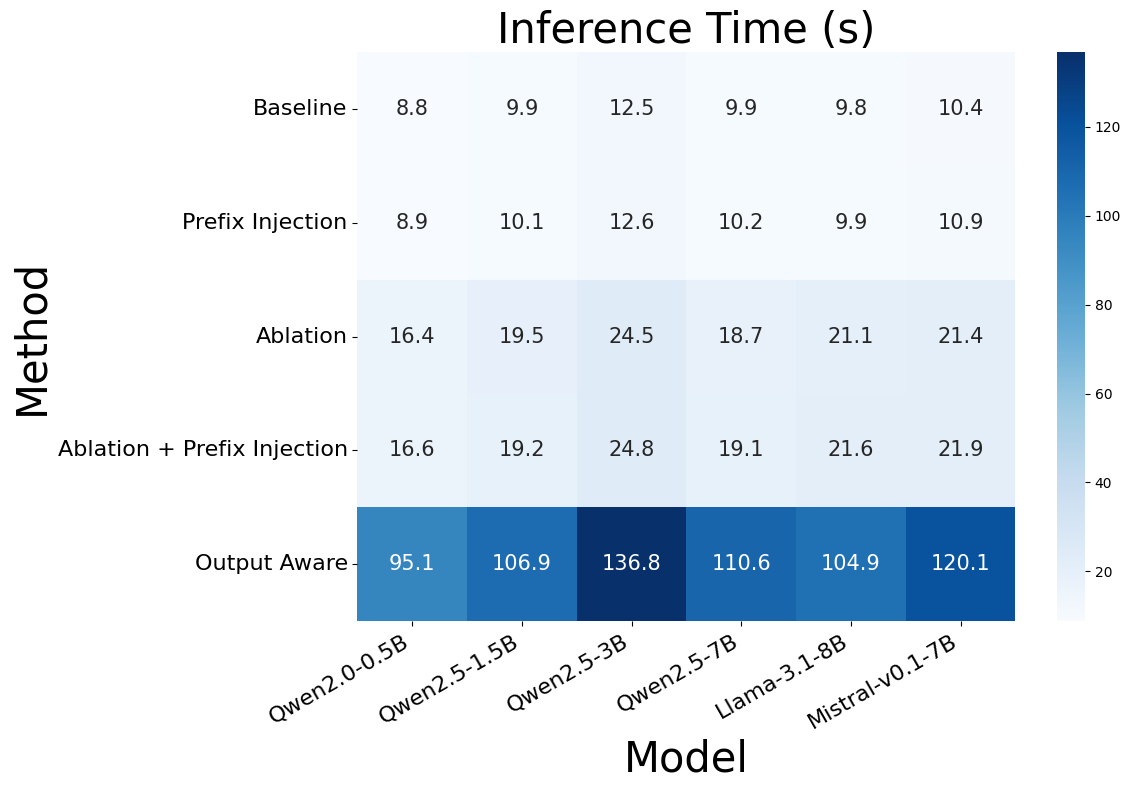

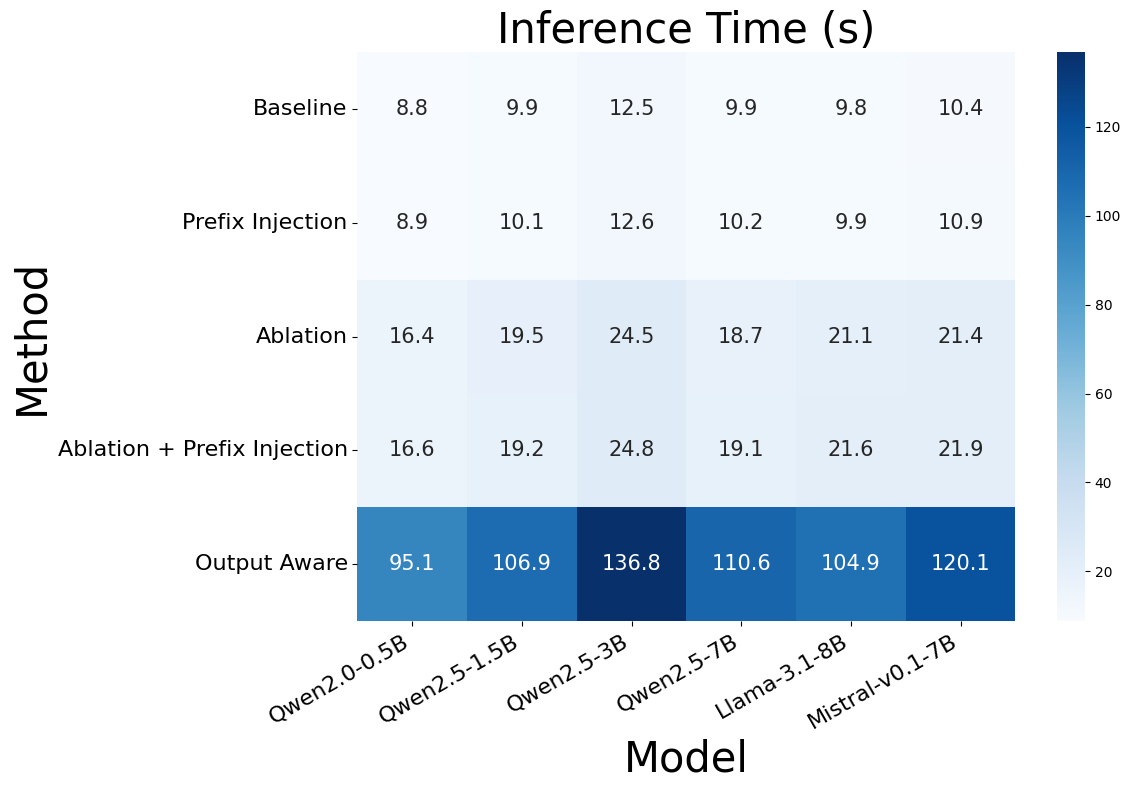

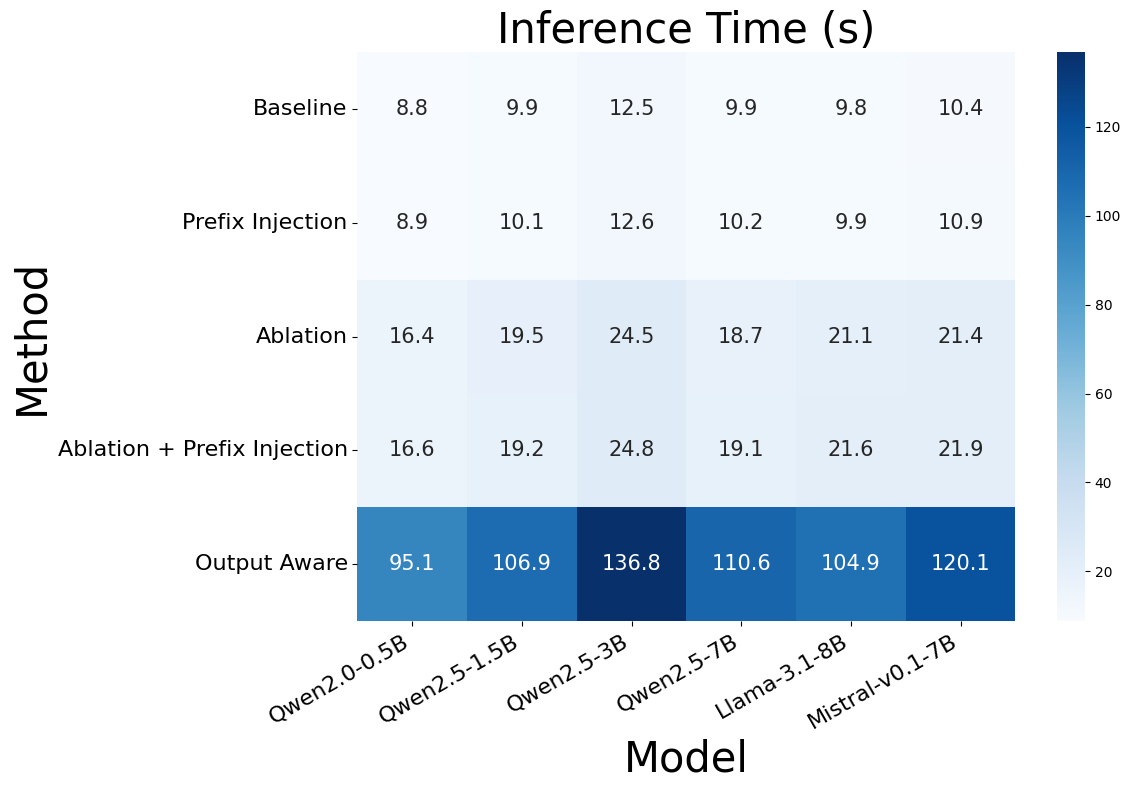

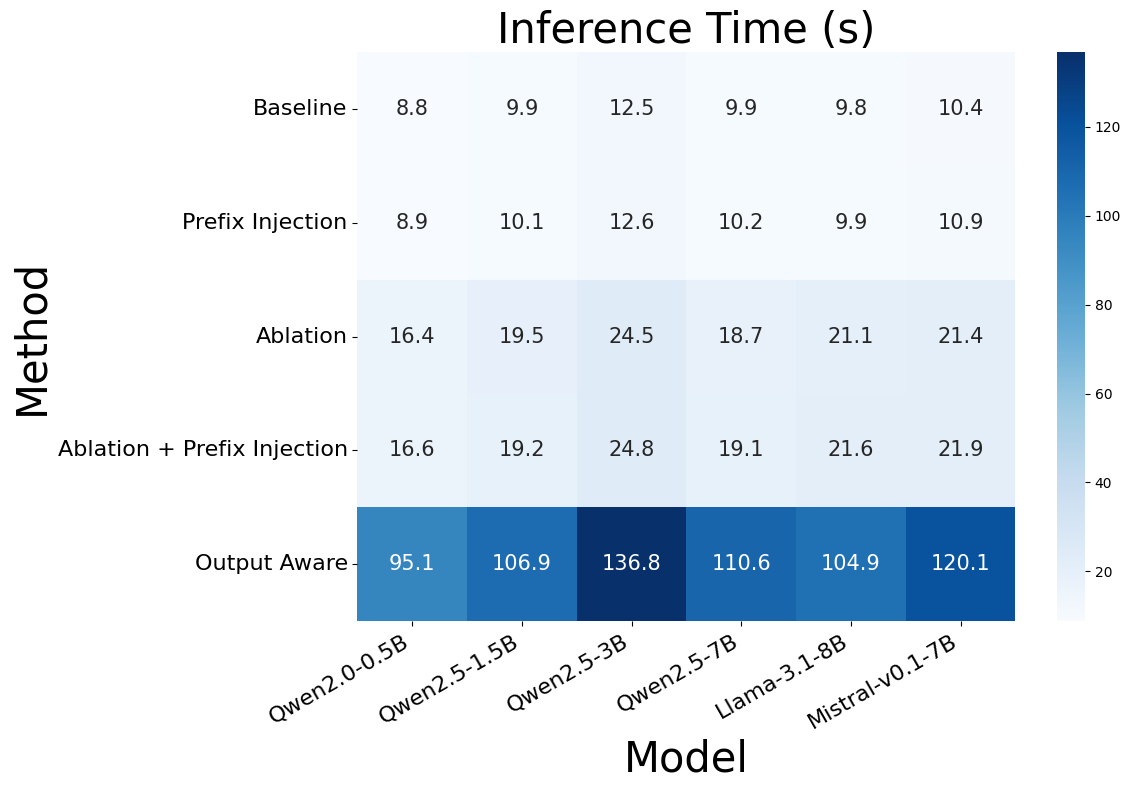

In [28]:
def create_metric_heatmap(df, metric_col=None, metric=None, source=None, title=None, cmap="YlGnBu", figsize=(12, 8), 
                          vmin=None, vmax=None, annot=True, fmt=".1f", annot_kws=None,
                          xlabel=None, ylabel=None, xlabel_fontsize=12, ylabel_fontsize=12, fontsize=12, cbar_kws=None):
    """
    Create a heatmap for a specific metric and source.
    
    Args:
        df: DataFrame from multi_evaluator_table
        metric: Metric name (e.g., "ASR", "attempt", "useful")
        source: Source name (e.g., "basline_6x5")
        title: Optional title for the heatmap
        cmap: Colormap to use
        figsize: Figure size as (width, height)
        vmin, vmax: Min and max values for color scaling
        annot: Whether to annotate cells
        fmt: Format string for annotations
        annot_kws: Additional kwargs for annotations
        xlabel: Custom x-axis label (default: None)
        ylabel: Custom y-axis label (default: None)
        xlabel_fontsize: Font size for x-axis label
        ylabel_fontsize: Font size for y-axis label
    """
    # Extract the average values for the specified metric and source
    if metric_col is None:
        avg_col = f"avg_{metric}_{source}"
    else:
        avg_col = metric_col
    
    if avg_col not in df.columns:
        print(f"Column {avg_col} not found in dataframe. Available columns: {df.columns}")
        return
    
    # Pivot the data to create a matrix suitable for heatmap
    pivot_df = df.pivot(index="method", columns="model", values=avg_col)
    
    # Create the figure and axes
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set default annotation parameters if not provided
    if annot_kws is None:
        annot_kws = {"size": 15}
    if cbar_kws is None:
        cbar_kws = {"shrink": 1.2}
    
    # Create the heatmap
    if metric == "gen_time":
        # For generation time, don't use percentage format
        sns.heatmap(pivot_df, annot=annot, fmt=fmt, cmap=cmap, 
                    vmin=vmin, vmax=vmax, annot_kws=annot_kws, ax=ax)
    else:
        # For percentage metrics, multiply by 100 and use percentage format
        sns.heatmap(pivot_df * 100, annot=annot, fmt=fmt, cmap=cmap, 
                    vmin=vmin, vmax=vmax, annot_kws=annot_kws, ax=ax)
    
    # Set title if provided
    if title:
        ax.set_title(title, fontsize=fontsize)
    else:
        ax.set_title(f"{metric.capitalize()} by Method and Model", fontsize=fontsize)
    
    # Set custom axis labels if provided
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=xlabel_fontsize)
    
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=ylabel_fontsize)
    
    # Rotate x-axis labels for better readability
    #plt.xticks(rotation=45, ha="right")
    plt.xticks(rotation=30, ha="right", fontsize=16,)# fontweight='bold')
    plt.yticks(rotation=0, ha="right", fontsize=16,) #fontweight='bold')


    
    # Adjust layout
    plt.tight_layout()
    
    return ax
titles = [
    "Attempt Success Rate (%)",
    "Attack Success Rate (%) (Substrings)",

    "Attack Success Rate (%) (LLM)",
    "Response Quality (%)",
]

# i = 0
# print(project_name)
# for col in df.columns:
#     if "avg" in col and not "gen_time" in col:
#         # Example usage with custom axis labels:
#         create_metric_heatmap(df, col, "", 
#                              title=f"{titles[i]}",
#                              cmap="YlOrRd",
#                              xlabel="Model",
#                              ylabel="Method",
#                              ylabel_fontsize=30,
#                              xlabel_fontsize=30,
#                              fontsize=30)
#         plt.show()
#         i += 1

# Another example with different labels
for col in df.columns:
    if "gen_time" in col:
        df[col] = df[col] * 100
        create_metric_heatmap(df, metric="gen_time", source=eval_run_ids[0], 
                            title="Inference Time (s)",
                            cmap="Blues",
                            xlabel="Model",
                            ylabel="Method",
                            fontsize=30,
                            ylabel_fontsize=30,
                            xlabel_fontsize=30)
        plt.show()

In [29]:
for i, col in enumerate(df.columns):
    print(f"{i}: {col}")

0: method
1: model
2: avg_attempt_qwen7B-v2
3: avg_gen_time_basline_6x5
4: avg_gen_time_qwen7B-v2
5: avg_ASR_basline_6x5
6: avg_ASR_qwen7B-v2
7: avg_useful_qwen7B-v2
8: ci_error_attempt_qwen7B-v2
9: ci_error_gen_time_basline_6x5
10: ci_error_gen_time_qwen7B-v2
11: ci_error_ASR_basline_6x5
12: ci_error_ASR_qwen7B-v2
13: ci_error_useful_qwen7B-v2


In [30]:

metric = "attempt"

metric_idx = [i for i, col in enumerate(df.columns) if (metric in col)]

column_idx = [0,1] + metric_idx
column_idx = metric_idx

result_df = df[[df.columns[idx] for idx in column_idx]]

print(result_df.to_string(index=False))

 avg_attempt_qwen7B-v2  ci_error_attempt_qwen7B-v2
                   NaN                         NaN
              0.168750                    0.014803
              0.929327                    0.010026
                   NaN                         NaN
              0.095673                    0.004086
                   NaN                         NaN
                   NaN                         NaN
              0.820192                    0.014622
              0.988942                    0.002149
                   NaN                         NaN
              0.229808                    0.007839
                   NaN                         NaN
                   NaN                         NaN
              0.940831                    0.011228
              0.997596                    0.001885
                   NaN                         NaN
              0.938462                    0.005591
                   NaN                         NaN
                   NaN         

In [31]:
import os

# Create a new dataframe with formatted values
formatted_df = pd.DataFrame()

# For each column in your result dataframe
for col in df.columns:
    # Format the values as "mean ± std"
    # Assuming you have mean and std values or can calculate them
    mean_values = result_df[col].mean()
    std_values = result_df[col].std()
    
    # Format to 3 decimal places
    formatted_df[col] = f"{mean_values:.3f} ± {std_values:.3f}"

# Save to CSV without index
path = 'examples/tables/ASR_baseline_table.csv'
os.makedirs(os.path.dirname(path), exist_ok=True)
formatted_df.to_csv(path, index=False)

# Display the formatted dataframe
formatted_df

KeyError: 'method'